# Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.58GB
Used: 601.87MB
Percentage: 3.7%


# GPU Information

In [2]:
! nvidia-smi

Thu Oct  8 06:33:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
from google.colab import drive
drive.mount('/content/gdrive2/')

Mounted at /content/gdrive2/


In [4]:
import time;
start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_Inp_Dataset_192.zip' -d 'Data/'
print (time.time() - start)

229.5289969444275


In [5]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_GT_Dataset_192.zip' -d 'Data/Dataset/depth_'
print (time.time() - start)

71.3685188293457


In [6]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/bg_192.zip' -d 'Data/Dataset/bg_'
print (time.time() - start)

8.934728622436523


In [1]:
import os

list_m = os.listdir('Data/Dataset/mask_/mask') # dir is your directory path
list_f = os.listdir('Data/Dataset/fg_bg_/fg_bg') # dir is your directory path
list_d = os.listdir('Data/Dataset/depth_/depth') # dir is your directory path
list_b_temp = os.listdir('Data/Dataset/bg_/bg_192') # dir is your directory path

list_f.sort()
list_m.sort()
list_d.sort()
list_b_temp.sort()

list_b = []
for bg in list_b_temp:
    list_b += [bg]*4000

print('No. of fg_bg Images: ', len(list_f))
print('No. of mask Images: ', len(list_m))
print('No. of depth Images: ', len(list_d))
print('No. of backround Images: ', len(list_b))

No. of fg_bg Images:  400000
No. of mask Images:  400000
No. of depth Images:  400000
No. of backround Images:  400000


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

In [3]:
# Shuffling the Dataset
import random

for _ in range(17):
    seed = random.random()
    def rand_num():
        return seed
    random.shuffle(list_f, rand_num)
    random.shuffle(list_b, rand_num)

#Testing if Randomizing worked
print(list_f[351275])
print(list_b[351275])

bg192_20_fg1797.jpg
bg192_20.jpg


In [4]:
#Creating Split of Data for Training and Testing of 70:30
train_split = int(len(list_f)*0.70)
train_data = list_f[0:train_split]
test_data = list_f[train_split:]
print(len(train_data), len(test_data))

280000 120000


In [5]:
from Data import DepMaskDataset
train_dataset = DepMaskDataset(train_data)
test_dataset = DepMaskDataset(test_data)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=96, shuffle=False, num_workers=4)

In [7]:
print(len(train_loader)) # Number of Train Batches
print(len(test_loader)) # Number of Test Batches 

2917
1250


In [8]:
data = next(iter(train_loader))
print(type(data))
print(len(data))

<class 'dict'>
4


In [9]:
print('Number of fg_bg Images in one batch: ', data['fgbg'].shape)
print('Number of bg Images in one batch: ', data['bg'].shape)
print('Number of mask Images in one batch: ', data['mask'].shape)
print('Number of depth Images in one batch: ', data['depth'].shape)

Number of fg_bg Images in one batch:  torch.Size([96, 3, 192, 192])
Number of bg Images in one batch:  torch.Size([96, 3, 192, 192])
Number of mask Images in one batch:  torch.Size([96, 1, 192, 192])
Number of depth Images in one batch:  torch.Size([96, 1, 192, 192])


In [10]:
from UNet_7M import UNet
from loss import BCEDiceLoss, RMSELoss, rmse, miou
import torch.optim as optim
from tqdm import tqdm
import gc

In [11]:
model = UNet(6).to('cuda')
optimizer = optim.Adam(model.parameters())

In [12]:
# checkpoint = torch.load('/content/gdrive/My Drive/Pull-0-Depth/model_weights_UNet7m/weights_ep5.pth') #Contunuing From 5th Epoch
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [13]:
from torchsummary import summary
summary(model, (6,192,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 192]           1,728
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              ReLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 32, 192, 192]           9,216
       BatchNorm2d-5         [-1, 32, 192, 192]              64
              ReLU-6         [-1, 32, 192, 192]               0
        DoubleConv-7  [[-1, 32, 192, 192], [-1, 32, 192, 192]]               0
         MaxPool2d-8           [-1, 32, 96, 96]               0
            Conv2d-9           [-1, 64, 96, 96]          18,432
      BatchNorm2d-10           [-1, 64, 96, 96]             128
             ReLU-11           [-1, 64, 96, 96]               0
           Conv2d-12           [-1, 64, 96, 96]          36,864
      BatchNorm2d-13           [-1, 64, 96, 96]             128
             ReLU-14    

In [14]:
from train import train
from test import test

In [27]:
start_process = time.time()
for i in range(4,5):
    epoch_time = time.time()
    train(train_loader, model, optimizer)
    print(f'********* EPOCH {i} TIME: {time.time()-epoch_time} seconds')
    print('******************************************************************************************************************')
torch.cuda.empty_cache()
fgbg, bg, mask_gt, depth_gt, mask_pred, depth_pred = test(test_loader, model, optimizer)
print('Total Time: ', time.time() - start_process)

100%|██████████| 2917/2917 [31:46<00:00,  1.53it/s]



Load Time:  1809.6104426383972
Prediciton Time:  24.940542459487915
Loss Time:  5.338430404663086
Backprop Time:  49.74549627304077
Total Time for One Batch:  1906.1413881778717
********************* LOSSES ****************************
Segmentation Loss:  1.09678053855896
Depth Loss:  0.0686979666352272
Total Loss:  1.1654791831970215
mean IOU:  0.27232497930526733
mean RMSE:  0.0686979666352272
********************* ****** ****************************


  0%|          | 0/1250 [00:00<?, ?it/s]

********* EPOCH 4 TIME: 1906.9775848388672 seconds
******************************************************************************************************************


100%|██████████| 1250/1250 [04:55<00:00,  4.23it/s]


Load Time:  204.256281375885
Prediciton Time:  17.554166555404663
Loss Time:  4.306392192840576
Total Time for One Batch:  295.2393035888672
********************* LOSSES ****************************
Segmentation Loss:  1.0966299772262573
Depth Loss:  0.06754204630851746
Total Loss:  1.1641721725463867
mean IOU:  0.27217793464660645
mean RMSE:  0.06754204630851746
********************* ****** ****************************
Total Time:  2202.448385477066


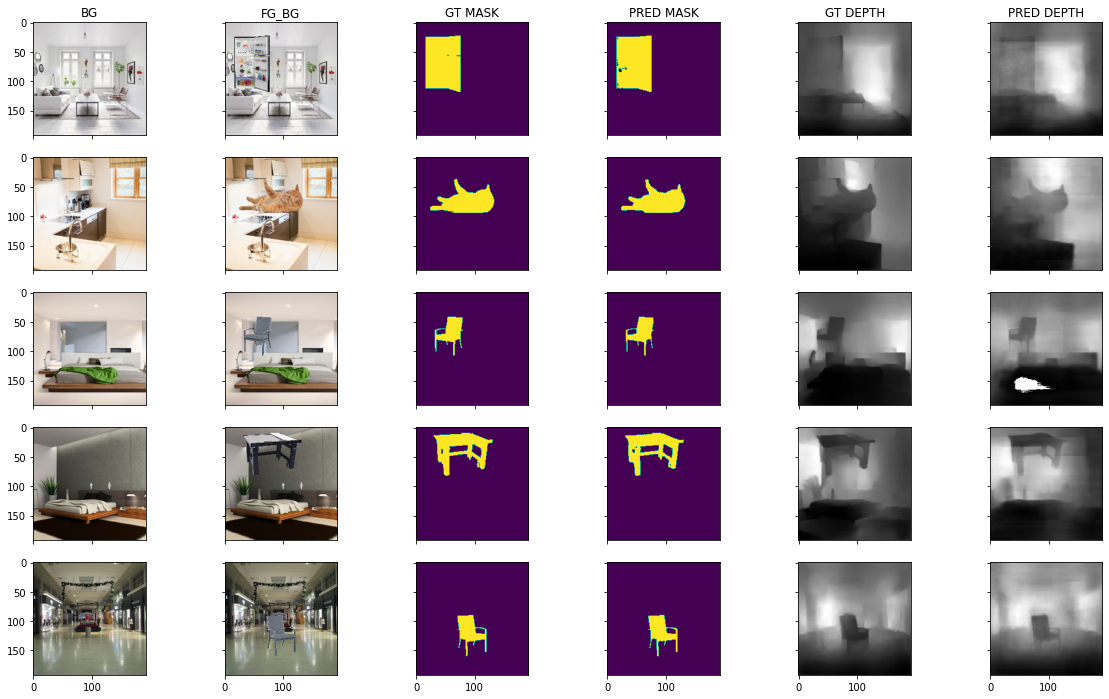

In [16]:
#Epoch 1 Results
from plot import plot
plot(fgbg, bg, mask_gt, mask_pred, depth_gt, depth_pred)

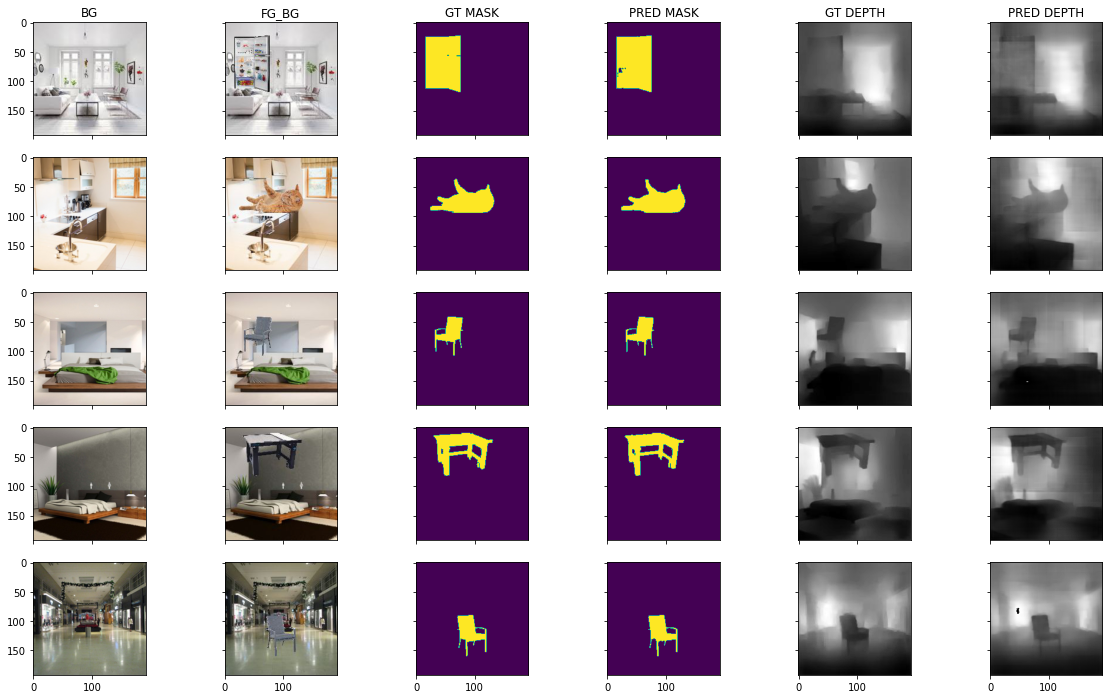

In [26]:
#Epoch 4 Results
from plot import plot
plot(fgbg, bg, mask_gt, mask_pred, depth_gt, depth_pred)